In [1]:
include("/Users/ct6g18/Julia/GLODAP_Section_Gridder/src/GLODAP_Section_Gridder.jl")
using MATLAB
using NCDatasets
using DataStructures
using CSV
using DataFrames
using Plots

So what I want to do is read in pred_theta_for_gridding, and write it to a random `expocode.mat` file. Then we can specify an exception dir wherever I've written it, and grid the output field from there.

In [2]:
df = CSV.read("/Users/ct6g18/Python/keras/ML_Carbon/pred_theta_all.csv",DataFrame)

colnames = [name for name in names(df)]
cruiseDict = Dict(zip(colnames, eachcol(df)))

cruiseDict = convert(Dict{String,Vector{Float64}},cruiseDict)

Dict{String, Vector{Float64}} with 9 entries:
  "G2gamma"           => [25.593, 25.6558, 26.0699, 26.3911, 26.5678, 26.6173, …
  "G2theta_actual"    => [21.3287, 21.286, 20.0529, 18.457, 18.1738, 17.9236, 1…
  "G2theta_predicted" => [23.903, 23.8014, 22.5836, 21.0428, 20.7275, 20.4193, …
  "G2pressure"        => [3.7, 26.2, 52.0, 77.2, 103.8, 127.6, 154.0, 205.3, 30…
  "G2year"            => [1992.0, 1992.0, 1992.0, 1992.0, 1992.0, 1992.0, 1992.…
  "G2latitude"        => [24.5027, 24.5027, 24.5027, 24.5027, 24.5027, 24.5027,…
  "G2station"         => [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0  …  …
  "DATE"              => [1992.07, 1992.07, 1992.07, 1992.07, 1992.07, 1992.07,…
  "G2longitude"       => [-16.933, -16.933, -16.933, -16.933, -16.933, -16.933,…

In [ ]:
# I now need to break this up based on date into a number of cruise dictionaries

# Then write a separate exception dir for each cruise. Finally, grid them all off,
# and then subtract the background field.

cruise1992 = cruise1998 = cruise2004 = cruise2010 = cruise2011 = cruiseDict

filter(cruise1992, cruise1992["G2year"] .> 1993.0)



In [3]:
cruise1992 = filter(:G2year => n ->        n < 1993, df)
cruise1998 = filter(:G2year => n -> 1997 < n < 1999, df)
cruise2004 = filter(:G2year => n -> 2003 < n < 2005, df)
cruise2010 = filter(:G2year => n -> 2009 < n < 2011, df)
cruise2011 = filter(:G2year => n -> 2010 < n       , df)


,G2longitude,G2latitude,G2year,G2pressure,G2gamma,G2station,G2theta_actual
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,-13.3418,27.7757,2011.0,78.233,26.2808,1.0,19.5
2,-13.3418,27.7757,2011.0,50.31,26.2651,1.0,19.58
3,-13.3418,27.7757,2011.0,50.197,26.2635,1.0,19.59
4,-13.3418,27.7757,2011.0,26.064,26.26,1.0,19.6
5,-13.3418,27.7757,2011.0,26.212,26.2599,1.0,19.6
6,-13.3418,27.7757,2011.0,4.941,26.2627,1.0,19.58
7,-13.3418,27.7757,2011.0,5.106,26.2624,1.0,19.58
8,-13.3418,27.7757,2011.0,5.258,26.2624,1.0,19.58
9,-13.3418,27.7757,2011.0,5.375,26.2624,1.0,19.58


In [12]:
cruise1998[!,"G2theta_predicted"]

excess1998 = cruise1998[!,"G2theta_actual"] - cruise1998[!,"G2theta_predicted"]
prs1998 = cruise1998[!,"G2pressure"]
lon1998 = cruise1998[!,"G2longitude"]



4308-element Vector{Float64}:
 -13.3698
 -13.3698
 -13.3698
 -13.3698
 -13.3698
 -13.3698
 -13.3698
 -13.3698
 -13.3698
 -13.401
   ⋮
 -79.857
 -79.857
 -79.857
 -79.857
 -79.937
 -79.937
 -79.937
 -79.937
 -79.937

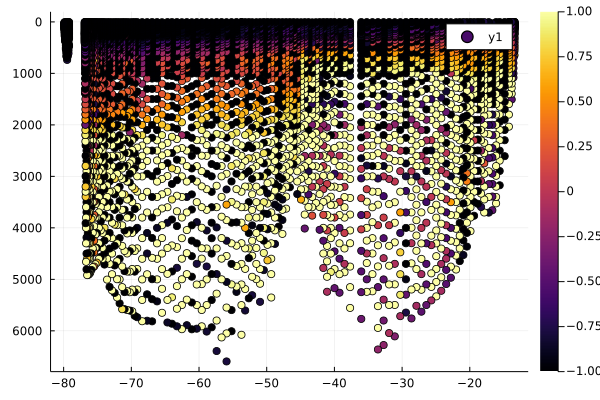

In [13]:
scatter(lon1998,prs1998,marker_z=excess1998,yflip=true,clim=(-1,1))

It looks like we're getting something which shows a systematic mismatch as a function of depth. This is obviously not quite the mismatch I was hoping for since the range is absolutely huge, but I think what I'm seeing is that the idea potentially has legs.

For a bit of a more rigourous test, lets just take the median as a function of depth. Every ten metres in the upper 500m, 50 metres in top 2000, 500 metres below that.

In [23]:
depth_range = [x for x = 0:10:500]
append!(depth_range, x for x = 550:50:2000)
append!(depth_range, x for x = 2500:500:6000)


bin_median_θe = fill(NaN,88)

using Statistics

for i = 2:89
    x = i - 1
    θe_tmp = filter(:G2pressure => n -> depth_range[x] < n < depth_range[i] , df)
    excess_tmp = θe_tmp[!,"G2theta_actual"] - θe_tmp[!,"G2theta_predicted"]
    bin_median_θe[x] = median(excess_tmp)
end
    

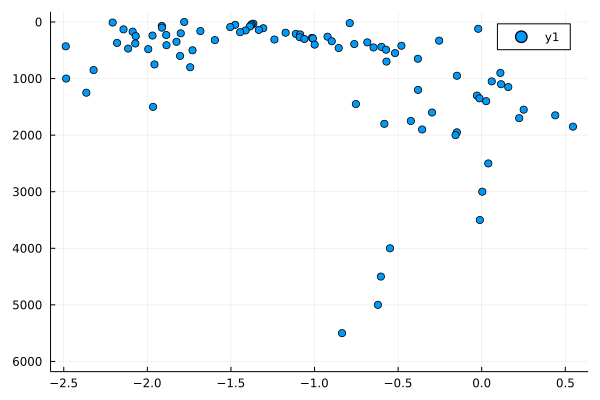

In [27]:
scatter(bin_median_θe, depth_range, yflip=true)

In [ ]:
GLODAP_Section_Gridder.writeCruiseException(outputExpocode="29HE19920714"
                                           ,cruiseDict=cruiseDict
                                           ,EXCEPTIONS_DIR="/Users/ct6g18/Python/keras/ML_Carbon")

In [ ]:
theta_actual = GLODAP_Section_Gridder.gridCruisePipeline(sectionName="A05"
                                                        ,horzCoordinate="longitude"
                                                        ,expocode="29HE19920714"
                                                        ,variableName="G2theta"
                                                        ,plotResults=true)

In [ ]:

exception_theta_actual = GLODAP_Section_Gridder.gridExceptionPipeline(sectionName="A05"
                                                      ,horzCoordinate="longitude"
                                                      ,expocode="29HE19920714"
                                                      ,variableName="theta_actual"
                                                      #,horzLenFactor=1000.0
                                                      ,EXCEPTIONS_DIR="/Users/ct6g18/Python/keras/ML_Carbon/ExceptionData/"
                                                      ,plotResults=true)

In [ ]:
exception_theta_pred = GLODAP_Section_Gridder.gridExceptionPipeline(sectionName="A05"
                                                      ,horzCoordinate="longitude"
                                                      ,expocode="29HE19920714"
                                                      ,variableName="theta_predicted"
                                                      #,horzLenFactor=1000.0
                                                      ,EXCEPTIONS_DIR="/Users/ct6g18/Python/keras/ML_Carbon/ExceptionData/"
                                                      ,plotResults=true)

In [ ]:
using Plots
heatmap(exception_theta_actual - exception_theta_pred,yflip=true,clim=(-1,1),c=:jet1)
contour!(exception_theta_actual - exception_theta_pred,yflip=true,levels=[i/10 for i in -4:2:4],c=:black)



It looks like I'm getting a pretty reasonable reproduction of the temperature field from the other tracers.